Names: Max Hammermann, Gerrit Gerhartz

# Introduction and Installation of Pytorch

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.nn.functional import conv2d, max_pool2d, cross_entropy

Initialize data-loaders:

In [ ]:
batch_size = 100

# transform images into normalized tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(
    "./",
    download=True,
    train=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    "./",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

Define optimizer and initialize weights of model:

In [ ]:
plt.rc("figure", dpi=100)

def init_weights(shape):
    # Kaiming He initialization (a good initialization is important)
    # https://arxiv.org/abs/1502.01852
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size=shape, dtype=torch.float64) * std
    w.requires_grad = True
    return w


def rectify(x):
    # Rectified Linear Unit (ReLU)
    return torch.max(torch.zeros_like(x), x)


class RMSprop(optim.Optimizer):
    """
    This is a reduced version of the PyTorch internal RMSprop optimizer
    It serves here as an example
    """
    def __init__(self, params, lr=1e-3, alpha=0.5, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # state initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(grad, avg, value=-group['lr'])


# define the neural network
def model(x, w_h, w_h2, w_o):
    h = rectify(x @ w_h)
    h2 = rectify(h @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax


# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o])

Train the NN for 100 epochs and monitor train- and validation loss for every 10 epochs:

In [ ]:
n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(1, n_epochs + 1):
    print(f"Epoch: {epoch}")
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = model(x, w_h, w_h2, w_o)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 1:
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = model(x, w_h, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

Epoch: 1
Mean Train Loss: 4.00e-01
Mean Test Loss:  1.61e-01
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Mean Train Loss: 1.59e-01
Mean Test Loss:  2.75e-01
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Mean Train Loss: 1.10e-01
Mean Test Loss:  3.58e-01
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Mean Train Loss: 8.10e-02
Mean Test Loss:  6.45e-01
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Mean Train Loss: 5.04e-02
Mean Test Loss:  6.54e-01
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Mean Train Loss: 3.83e-02
Mean Test Loss:  7.25e-01
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Mean Train Loss: 2.76e-02
Mean Test Loss:  8.15e-01
Epoch: 62
Epoch: 63
Epoch: 64
Epoch

Plot training- and validation loss:

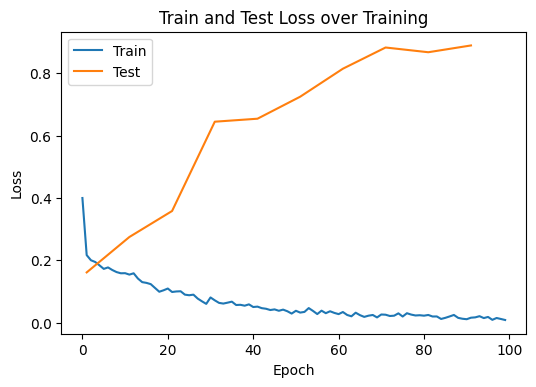

In [ ]:
plt.plot(np.arange(n_epochs), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

<div style="color: green; font-weight: bold">Code copied from the exercise sheet.</div>

 

As we can see, this model terribly overfits.

# Dropout Learning

First of all, we implement a dropout-function ``dropout``:

In [ ]:
def dropout(X, p_drop=0.5):
  if (p_drop > 0) and (p_drop < 1):
    phi = np.random.binomial(n = 1, p=p_drop, size = np.shape(X)).astype(np.float64)
    factor = np.empty(np.shape(X))
    factor[phi==0] = 1/(1-p_drop)
    factor[phi==1] = 0.
    X = X * torch.from_numpy(factor)
    return X
  elif p_drop==0:
    X = X.double()
    return X
  else:
    print('No valid dropout probability. Enter either 0 or a value between 0 and 1.')
  

<font color='green'><b> 
    
Similar solution. In sample solution 0 is treated as exception, here it is acceptable. It doesn't make any difference in implementation. 
    </b>

With this function, we can now implement a model, that uses dropout during learning. We therefore apply the dropout-function to the input of every layer:

In [ ]:
def dropout_model(X, w_h, w_h2, w_o, p_drop_input, p_drop_hidden):
  x = dropout(X, p_drop_input)
  h = rectify(x @ w_h)
  h = dropout(h, p_drop_hidden)
  h2 = rectify(h @ w_h2)
  h2 = dropout(h2, p_drop_hidden)
  pre_softmax = h2 @ w_o
  return pre_softmax

<font color='green'><b> 
    
The same as example solution  </b>

Train the dropout-model. For the test-evaluation, it is important that no dropout is applied, as neurons are normally only dropped during training and not during the validation-pass (no additional randomness on the trained model, that should be tested). Because of that, we are using the dropout-model with dropout-probability $p=0$ during the test-pass. For the training part, a dropout probability of $p=0.1$ is chosen.

In [ ]:
# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o])
n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(1, n_epochs + 1):
    print(f"Epoch: {epoch}")
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = dropout_model(x, w_h, w_h2, w_o, 0.1, 0.1)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 1:
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = dropout_model(x, w_h, w_h2, w_o, 0, 0)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

Epoch: 1
Mean Train Loss: 4.54e-01
Mean Test Loss:  1.73e-01
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Mean Train Loss: 2.41e-01
Mean Test Loss:  1.65e-01
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Mean Train Loss: 2.27e-01
Mean Test Loss:  4.16e-01
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Mean Train Loss: 2.16e-01
Mean Test Loss:  2.42e-01
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Mean Train Loss: 1.87e-01
Mean Test Loss:  3.54e-01
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Mean Train Loss: 2.02e-01
Mean Test Loss:  3.78e-01
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Mean Train Loss: 2.02e-01
Mean Test Loss:  4.51e-01
Epoch: 62
Epoch: 63
Epoch: 64
Epoch

The idea of dropout is that the trained model is more robust due to the fact that some neurons are switched of during training. Therefore, the dropout is one way to provide regularization effects in a FC-network, as one effectively trains many network configurations that differ a little.

One can see that the inclusion of dropout leads to a smaller validation loss. However, we observe that the validation loss varies a lot during the different evaluations.

<font color='green'><b> 
    
Similar to sample solution. Different dropout-probability but it's ok. Graph would be helpful. </b>

# Parametric ReLU

Define some helping-functions at the beginning:

In [ ]:
def PRelu(X, a):
  result = torch.empty(X.shape, dtype=torch.float64)
  mult = X * a
  result[X>0] = X[X>0]
  result[X<=0] = mult[X<=0]
  return result

Provide initialization for the parameter vector $a$:

In [ ]:
def a_init(size):
  a = torch.zeros(size)
  # assure that a is optimized during gradient computation
  a.requires_grad = True
  return a

Define model that incorporates Parametric ReLU:

In [ ]:
def para_relu_model(X, w_h, w_h2, w_o, a_h, a_h2, p_drop_input, p_drop_hidden):
  x = dropout(X, p_drop_input)
  h = PRelu(x @ w_h, a_h)
  h = dropout(h, p_drop_hidden)
  h2 = PRelu(h @ w_h2, a_h2)
  h2 = dropout(h2, p_drop_hidden)
  pre_softmax = h2 @ w_o
  return pre_softmax

COMMENT
`a_init` and `Para_relu_model` are the same as sample solution.

Initialize weights and train the model:

In [ ]:
# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)
# initialize a_h and a_h2
a_h = a_init((batch_size, 625))
a_h2 = a_init((batch_size, 625))

optimizer = RMSprop(params=[w_h, w_h2, w_o, a_h, a_h2])
n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(1, n_epochs + 1):
    print(f"Epoch: {epoch}")
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = para_relu_model(x, w_h, w_h2, w_o, a_h, a_h2, 0.1, 0.1)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 1:
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = para_relu_model(x, w_h, w_h2, w_o, a_h, a_h2, 0, 0)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

Epoch: 1
Mean Train Loss: 4.64e-01
Mean Test Loss:  2.41e-01
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Mean Train Loss: 1.65e-01
Mean Test Loss:  1.37e-01
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Mean Train Loss: 1.22e-01
Mean Test Loss:  1.26e-01
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Mean Train Loss: 1.06e-01
Mean Test Loss:  1.48e-01
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Mean Train Loss: 1.03e-01
Mean Test Loss:  1.76e-01
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Mean Train Loss: 1.05e-01
Mean Test Loss:  2.12e-01
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Mean Train Loss: 1.03e-01
Mean Test Loss:  2.17e-01
Epoch: 62
Epoch: 63
Epoch: 64
Epoch

We can see that the additional weight vector in the activation layer helps to improve the performance, as train- and test loss become closer and smaller than before. However, the NN still overfits the data.

<font color='green'><b> 

Similar solution to sample solution.  Graph would be helpful. </b>

# Convolutional layers

## Creation of a convolutional neural network

We can now implement the convolutional neural network with three convolutional layers.

In [ ]:
def conv_network(X, conv_weight_1, conv_weight_2, conv_weight_3, w_h2, w_o, p_drop_input, p_drop_hidden):
  # input dropout
  x = dropout(X, p_drop_input)
  # first convolution and pooling block
  conv_1 = rectify(conv2d(x, conv_weight_1))
  subsampl_1 = max_pool2d(conv_1, (2,2))
  drop_1 = dropout(subsampl_1, p_drop_hidden)
  # second convolution and pooling block
  conv_2 = rectify(conv2d(drop_1, conv_weight_2))
  subsampl_2 = max_pool2d(conv_2, (2,2))
  drop_2 = dropout(subsampl_2, p_drop_hidden)
  # third convolution and pooling block
  conv_3 = rectify(conv2d(drop_2, conv_weight_3))
  subsampl_3 = max_pool2d(conv_3, (2,2))
  drop_3 = dropout(subsampl_3, p_drop_hidden)

  # flatten drop_3 output and start fully-connected architecture (128 hidden channels)
  h2 = rectify(torch.reshape(drop_3, (batch_size, 128)) @ w_h2)
  h2 = dropout(h2, p_drop_hidden)
  pre_softmax = h2 @ w_o
  return pre_softmax


Initialize weights according to table on exercise sheet:

In [ ]:
conv_weight_1 = init_weights((32, 1, 5, 5))
conv_weight_2 = init_weights((64, 32, 5, 5))
conv_weight_3 = init_weights((128, 64, 2, 2))
w_h2 = init_weights((128, 625))
w_o = init_weights((625, 10))

<font color='green'><b> 

`conv_network` and initializing weights are the same as sample solution  </b>

## Application of Convolutional network

Train the network for 16 epochs (according to hint on discord). The sketch of the network is shown at the end of the notebook.

In [ ]:
optimizer = RMSprop(params=[w_h2, w_o, conv_weight_1, conv_weight_2, conv_weight_3])
n_epochs = 15

train_loss = []
test_loss = []

# put this into a training loop over 16 epochs
for epoch in range(1, n_epochs + 2):
    print(f"Epoch: {epoch}")
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model (get dimensions of x like indicated on the sheet)
        noise_py_x = conv_network(x.view(-1, 1, 28, 28), conv_weight_1, conv_weight_2, conv_weight_3, w_h2, w_o, 0.1, 0.1)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 3 == 1:
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = conv_network(x.view(-1, 1, 28, 28), conv_weight_1, conv_weight_2, conv_weight_3, w_h2, w_o, 0, 0)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

Epoch: 1
Mean Train Loss: 1.19e+00
Mean Test Loss:  1.56e-01
Epoch: 2
Epoch: 3
Epoch: 4
Mean Train Loss: 2.24e-01
Mean Test Loss:  8.40e-02
Epoch: 5
Epoch: 6
Epoch: 7
Mean Train Loss: 2.57e-01
Mean Test Loss:  1.01e-01
Epoch: 8
Epoch: 9
Epoch: 10
Mean Train Loss: 2.76e-01
Mean Test Loss:  9.45e-02
Epoch: 11
Epoch: 12
Epoch: 13
Mean Train Loss: 2.84e-01
Mean Test Loss:  1.09e-01
Epoch: 14
Epoch: 15
Epoch: 16
Mean Train Loss: 3.05e-01
Mean Test Loss:  7.63e-02


<font color='green'><b>

Similar solution to the samplw solution. Graph would be helpful. Different number of epochs and dropout-probability used but it's ok. </b>

We can now perform some investigation on the individual filter outputs. Plot one image, the resulting outputs of three filters in the first convolutional layer and the trained weights.

In [ ]:
# get element from test loader 
x_bat, y_bat = next(iter(test_dataloader))
# plug into first conv_layer
out = conv2d(x_bat.view(-1, 1, 28, 28), conv_weight_1.float())

torch.Size([100, 32, 24, 24])

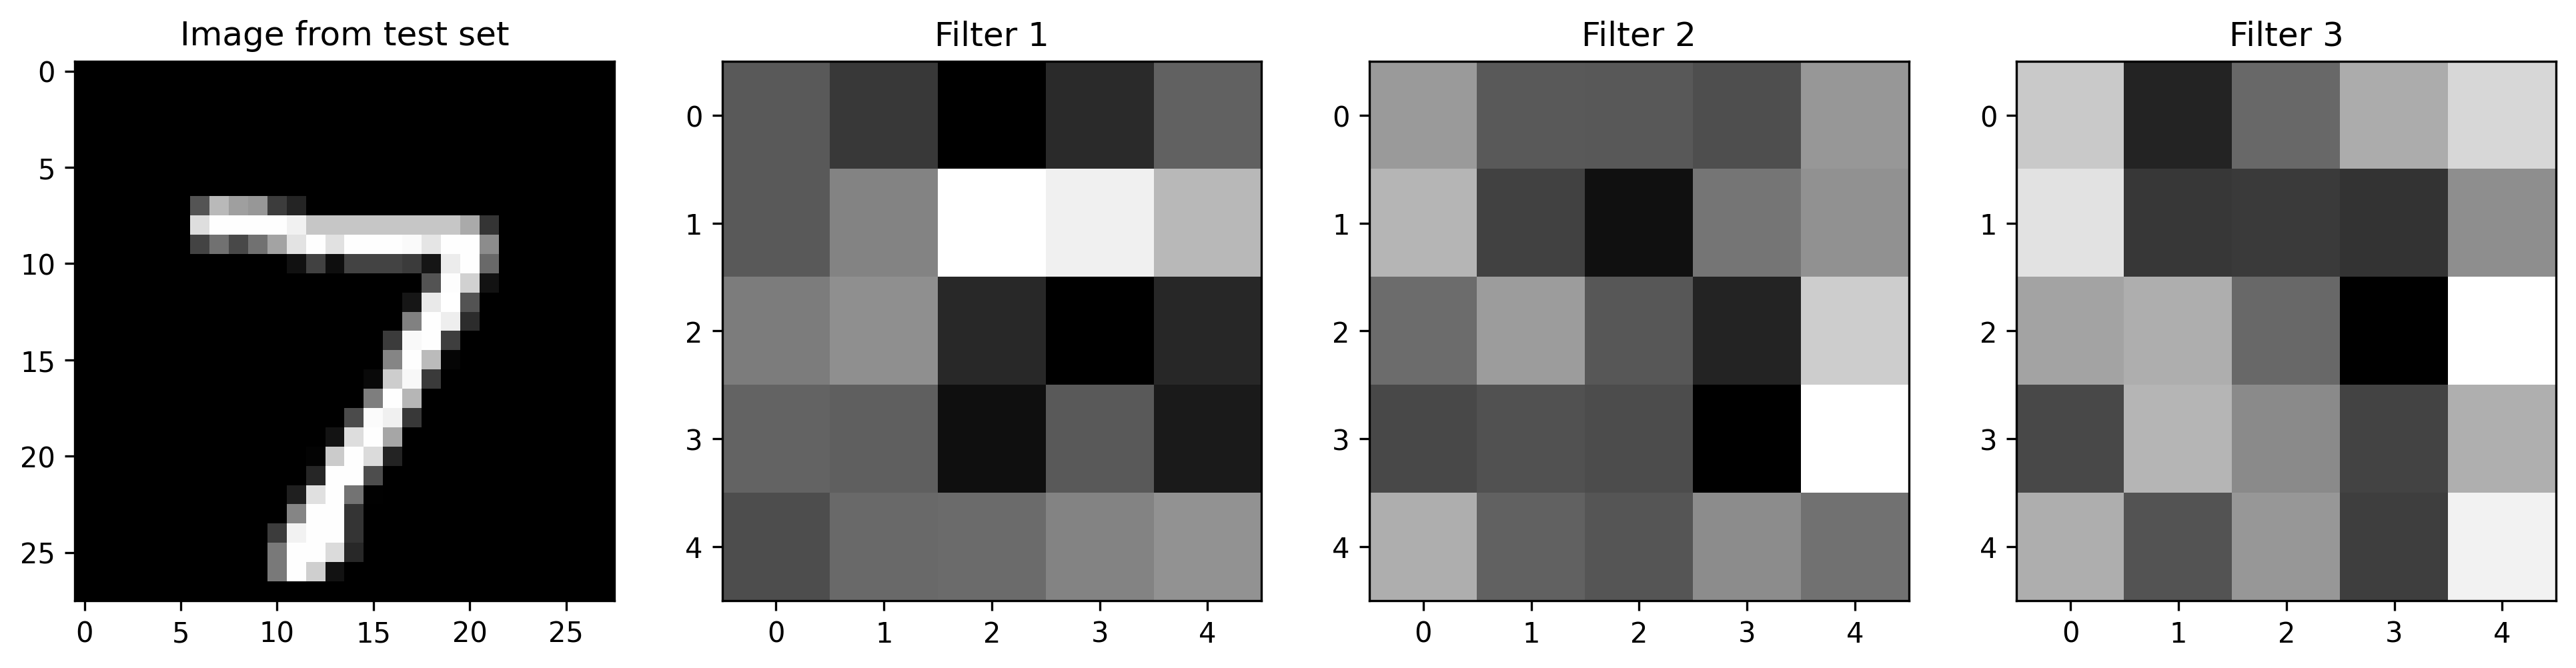

In [ ]:
plt.figure(dpi=300, figsize= (16,4))
plt.gray()
plt.subplot(141)
plt.title('Image from test set')
plt.imshow(x_bat[0][0].numpy())
plt.subplot(142)
plt.title('Filter 1')
plt.imshow(conv_weight_1[0, 0, :, :].detach().numpy())
plt.subplot(143)
plt.title('Filter 2')
plt.imshow(conv_weight_1[1, 0, :, :].detach().numpy())
plt.subplot(144)
plt.title('Filter 3')
plt.imshow(conv_weight_1[2, 0, :, :].detach().numpy())

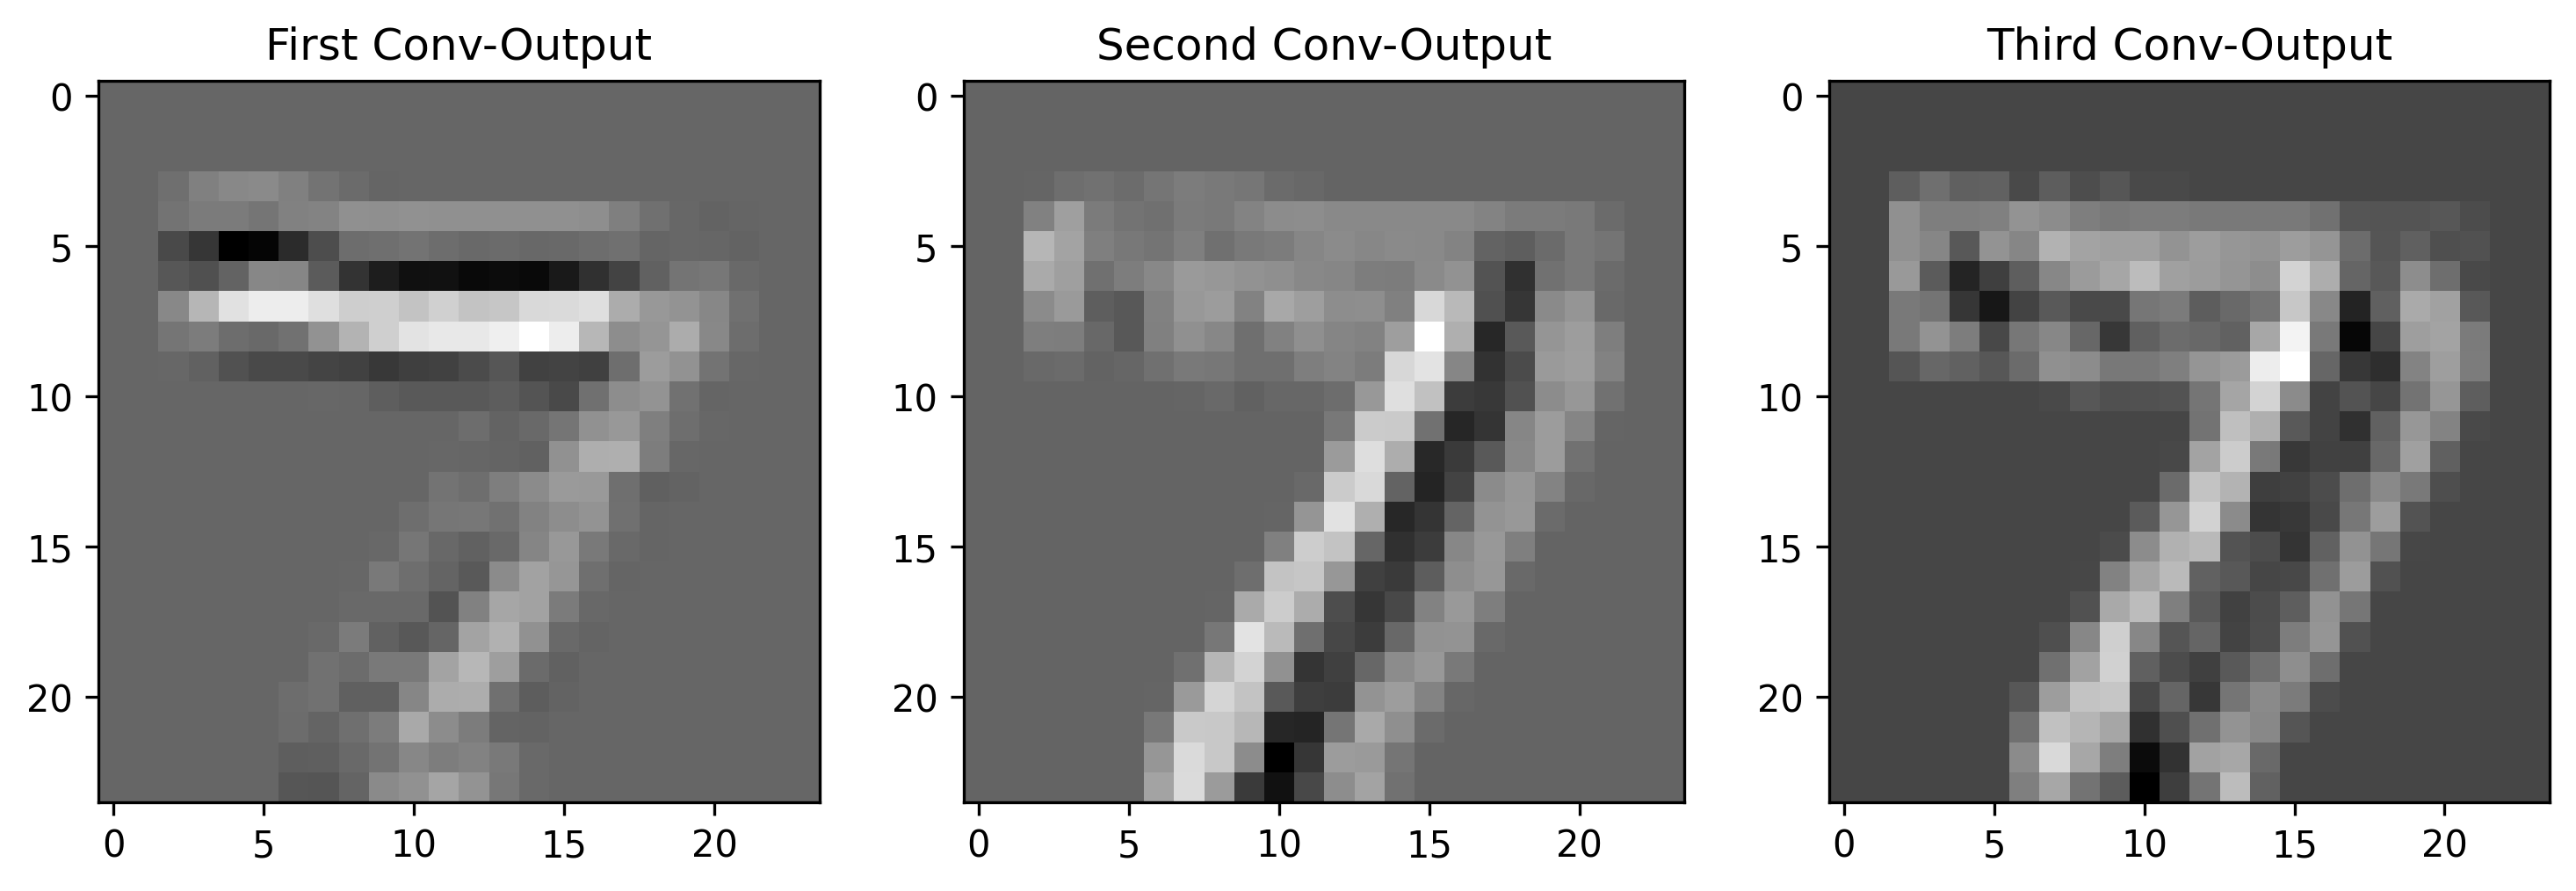

In [ ]:
plt.figure(dpi=300, figsize= (12,4))
plt.subplot(131)
plt.title('First Conv-Output')
plt.imshow(out[0, 0, :, :].detach().numpy())
plt.subplot(132)
plt.title('Second Conv-Output')
plt.imshow(out[0, 1, :, :].detach().numpy())
plt.subplot(133)
plt.title('Third Conv-Output')
plt.imshow(out[0, 2, :, :].detach().numpy())


<font color='green'><b>

Plotting filters and examples similar to the sample solution. </b>

Furthermore, we investigate how the change to unisotropic filters has an impact on the performance of the CNN:

In [ ]:
conv_weight_1 = init_weights((32, 1, 3, 5))
conv_weight_2 = init_weights((64, 32, 5, 4))
conv_weight_3 = init_weights((128, 64, 3, 2))
w_h2 = init_weights((128, 625))
w_o = init_weights((625, 10))

In [ ]:
optimizer = RMSprop(params=[w_h2, w_o, conv_weight_1, conv_weight_2, conv_weight_3])
n_epochs = 15

train_loss = []
test_loss = []

# put this into a training loop over 16 epochs
for epoch in range(1, n_epochs + 2):
    print(f"Epoch: {epoch}")
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model (get dimensions of x like indicated on the sheet)
        noise_py_x = conv_network(x.view(-1, 1, 28, 28), conv_weight_1, conv_weight_2, conv_weight_3, w_h2, w_o, 0.1, 0.1)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 3 == 1:
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = conv_network(x.view(-1, 1, 28, 28), conv_weight_1, conv_weight_2, conv_weight_3, w_h2, w_o, 0, 0)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

Epoch: 1
Mean Train Loss: 9.01e-01
Mean Test Loss:  1.43e-01
Epoch: 2
Epoch: 3
Epoch: 4
Mean Train Loss: 1.94e-01
Mean Test Loss:  7.38e-02
Epoch: 5
Epoch: 6
Epoch: 7
Mean Train Loss: 2.26e-01
Mean Test Loss:  9.35e-02
Epoch: 8
Epoch: 9
Epoch: 10
Mean Train Loss: 2.43e-01
Mean Test Loss:  7.50e-02
Epoch: 11
Epoch: 12
Epoch: 13
Mean Train Loss: 2.52e-01
Mean Test Loss:  9.29e-02
Epoch: 14
Epoch: 15
Epoch: 16
Mean Train Loss: 2.69e-01
Mean Test Loss:  7.85e-02


We can see, that the difference to the test error before is not to large. Finally, we can draw the resulting network:

<font color='green'><b> 

Unisotropic filters part is correct. </b>

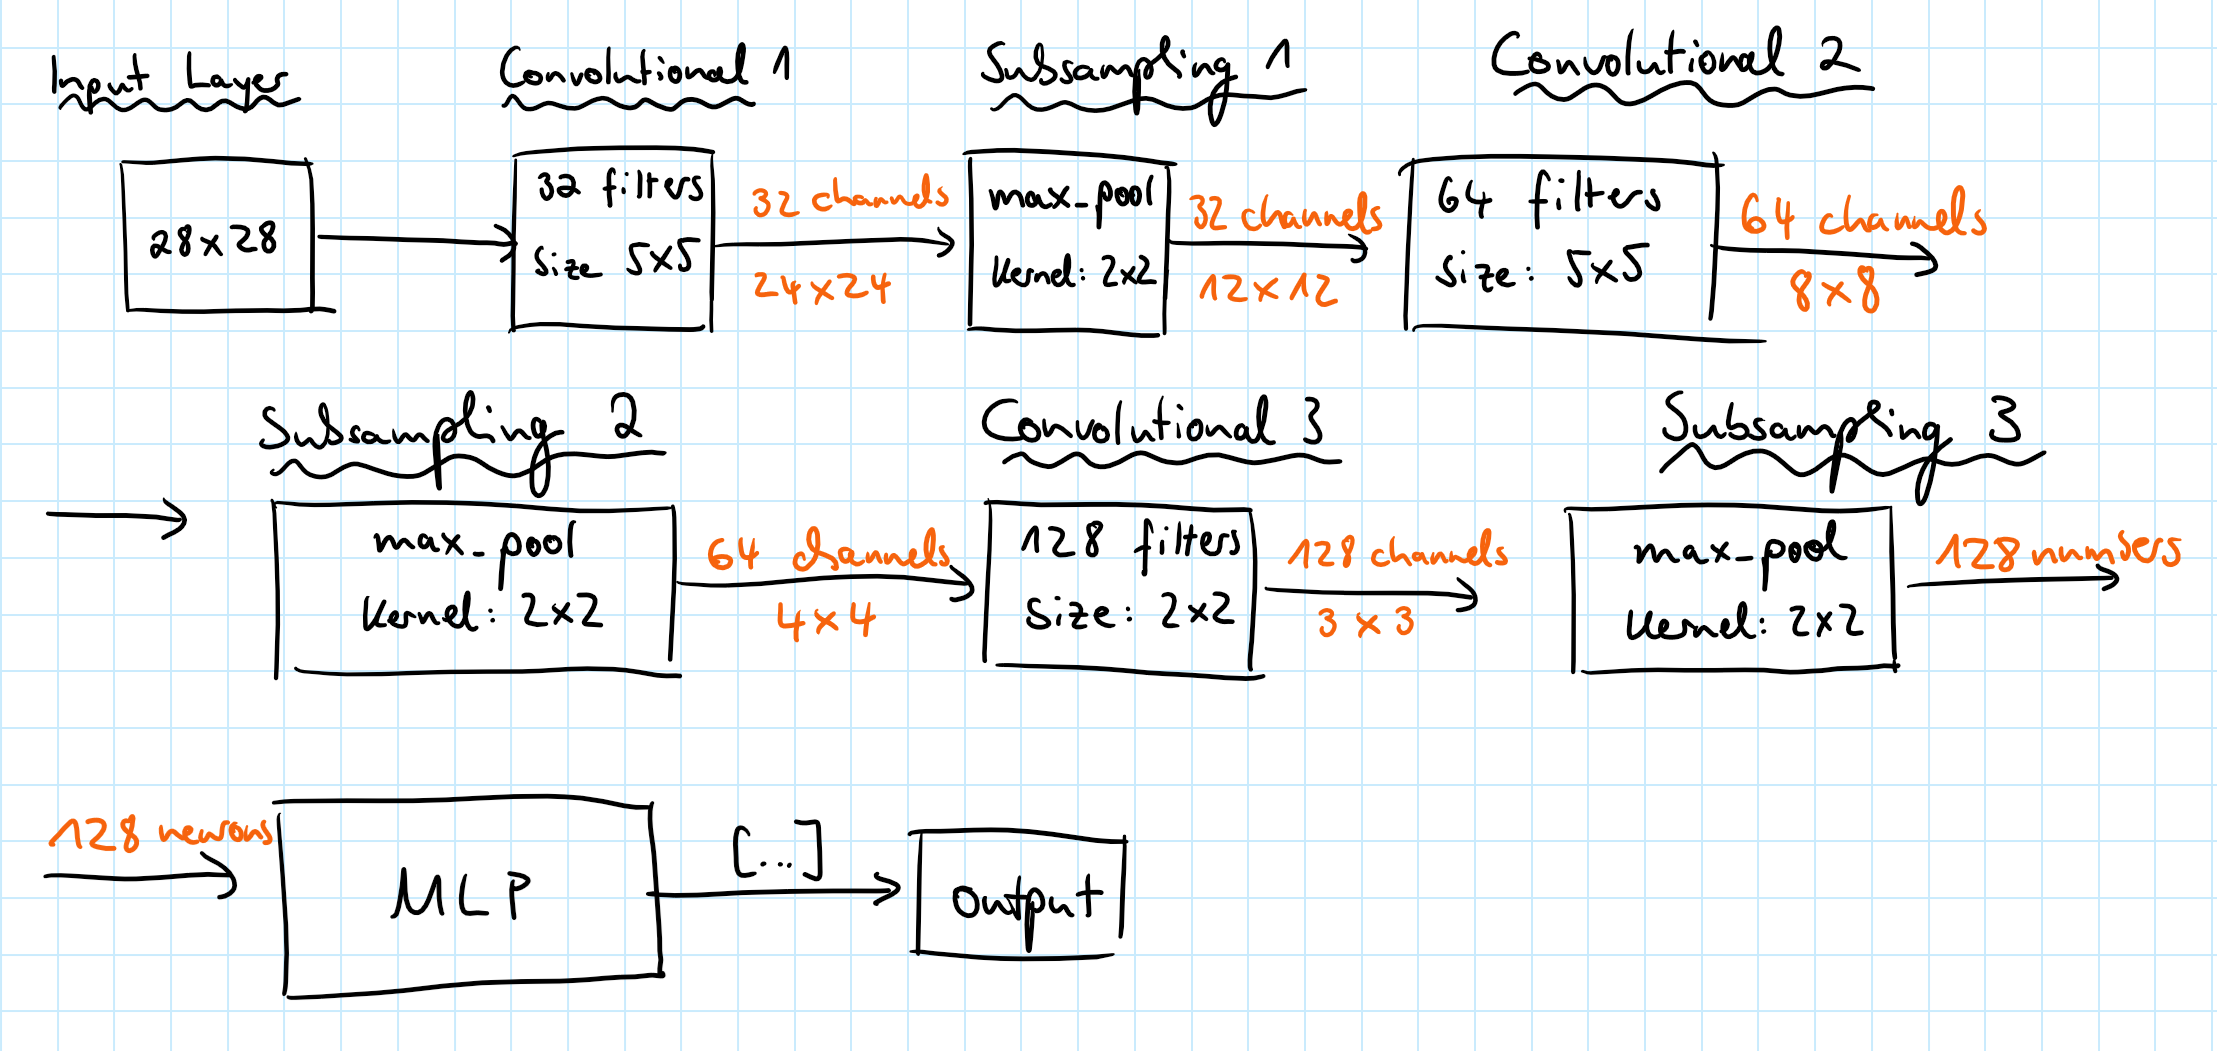

In [1]:
from IPython.display import Image
Image(filename='Network_Sketch.png')

<font color='green'><b> 

Scheme is correct. Dimentions of the MLP are missing but they were defined during weights initialization. </b>